In [1]:
import numpy as np 
import cv2
import os
import re

In [2]:
import matplotlib.pyplot as plt

In [3]:
#  For correct sorting.
def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [atoi(c) for c in re.split('(\d+)', text)]

In [32]:
path = '/home/aviad/Desktop/src/data/Images/rgbd_dataset_freiburg3_structure_notexture_far/rgb'

In [4]:
path = '/home/aviad/Desktop/src/data/Images/odo360nodoor/odo360nodoor_orginal'

In [33]:
images = os.listdir(path)
images.sort(key=natural_keys)

In [34]:
prevImg = cv2.imread(path+'/'+images[0],0)
nextImg = cv2.imread(path+'/'+images[1],0)

In [35]:
import matplotlib.pyplot as plt

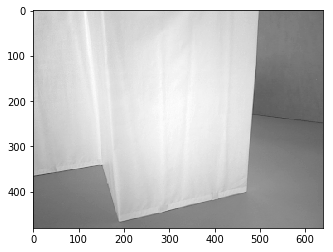

In [38]:
plt.imshow(prevImg, cmap='gray')
plt.show()

In [39]:
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

In [40]:
prevPts = cv2.goodFeaturesToTrack(prevImg, mask = None, **feature_params)

In [41]:
print prevPts

[[[152. 344.]]

 [[191. 463.]]

 [[635. 248.]]

 [[469. 397.]]]


In [9]:
def createLineIterator(P1, P2, img):
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = int(np.abs(dX))
    dYa = int(np.abs(dY))
        
    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),2),dtype=np.float64)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32)/dY.astype(np.float32)
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
        else:
            slope = dY.astype(np.float32)/dX.astype(np.float32)
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
#     itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer

In [42]:
morePoint = list(createLineIterator(prevPts[0][0],prevPts[1][0],nextImg))

In [43]:
prevPtsTemp = list(prevPts)

In [44]:
for point in morePoint:    
    prevPtsTemp.append(np.array([point],dtype=np.float32))

In [45]:
prevPts = np.array(prevPtsTemp)

In [46]:
mask = np.zeros_like(prevImg)

In [47]:
# Setup
lk_params = dict(winSize = (21, 21),
                 maxLevel = 3,
                criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

In [48]:
nextPts, st, err = cv2.calcOpticalFlowPyrLK(prevImg,
                                        nextImg,
                                        prevPts,
                                        None,
                                        **lk_params)

In [49]:
good_next = nextPts[st==1]
good_prev = prevPts[st==1]

In [50]:
print len(nextPts)

123


In [62]:
pp2 = (539.597659, 247.05382035)
f = 319.1836410

In [51]:
pp2 = (180.26971744, 318.64700156)
f = 281.36196961

In [63]:
E, mask = cv2.findEssentialMat(nextPts,prevPts,f,pp2,0,0.999,0.1,mask)

In [64]:
_, cur_R, cur_t, mask, = cv2.recoverPose(E, nextPts, prevPts, focal = f, pp = pp2)

In [65]:
print cur_R

[[ 9.99998088e-01  1.94225924e-03  2.28734265e-04]
 [-1.94329161e-03  9.99987517e-01  4.60317032e-03]
 [-2.19790860e-04 -4.60360602e-03  9.99989379e-01]]


In [66]:
print cur_t

[[ 0.65144259]
 [-0.46063346]
 [-0.60285932]]


In [67]:
P = np.concatenate((cur_R, cur_t), axis=1)

In [68]:
print P

[[ 9.99998088e-01  1.94225924e-03  2.28734265e-04  6.51442594e-01]
 [-1.94329161e-03  9.99987517e-01  4.60317032e-03 -4.60633458e-01]
 [-2.19790860e-04 -4.60360602e-03  9.99989379e-01 -6.02859324e-01]]


In [75]:
P2 = np.array([[-0.4563, 0.2444, -0.8556, -1.2432 ], 
[0.8898, 0.1249, -0.4388, 1.9219],
[-0.0004, -0.9616, -0.2745, 1.0547]])

In [79]:
print P2

[[-4.5630e-01  2.4440e-01 -8.5560e-01 -1.2432e+00]
 [ 8.8980e-01  1.2490e-01 -4.3880e-01  1.9219e+00]
 [-4.0000e-04 -9.6160e-01 -2.7450e-01  1.0547e+00]]


In [69]:
cur_pos = -np.matrix(cur_R).T * np.matrix(cur_t)

In [70]:
cur_rot = cv2.decomposeProjectionMatrix(P)[-1]

In [76]:
cur_rot = cv2.decomposeProjectionMatrix(P2)[-1]

In [78]:
print cur_rot

[[-1.05932017e+02]
 [ 2.29180263e-02]
 [ 1.17145692e+02]]


In [ ]:
-1.2432, 1.9219, 1.0547; 2.04464, 0.000360791, -1.84887

In [72]:
pose3d = np.concatenate((cur_pos,cur_rot))
print pose3d

[[-0.652469  ]
 [ 0.45658711]
 [ 0.60482429]
 [-0.26376813]
 [ 0.01259309]
 [-0.11134248]]


In [31]:
current_pos = np.zeros((3, 1))
current_rot = np.eye(3)

In [33]:
print current_pos
print current_rot

[[0.]
 [0.]
 [0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [34]:
scale = 1.0

In [36]:
current_pos += current_rot.dot(cur_t) * scale
current_rot = cur_R.dot(current_rot)

In [37]:
print current_pos
print current_rot

[[-0.94966142]
 [-0.15219137]
 [ 0.27382655]]
[[ 0.80067675 -0.29546771  0.52116751]
 [ 0.29672888  0.95130771  0.0834603 ]
 [-0.52045049  0.08782073  0.84936377]]


In [78]:
Pose_2 = np.hstack((cur_R, cur_t))
print ("Pose_2: ", Pose_2)

('Pose_2: ', array([[ 0.80067675, -0.29546771,  0.52116751, -0.94966142],
       [ 0.29672888,  0.95130771,  0.0834603 , -0.15219137],
       [-0.52045049,  0.08782073,  0.84936377,  0.27382655]]))


In [83]:
# epsilon for testing whether a number is close to zero
_EPS = np.finfo(float).eps * 4.0

# axis sequences for Euler angles
_NEXT_AXIS = [1, 2, 0, 1]

# map axes strings to/from tuples of inner axis, parity, repetition, frame
_AXES2TUPLE = {
    'sxyz': (0, 0, 0, 0), 'sxyx': (0, 0, 1, 0), 'sxzy': (0, 1, 0, 0),
    'sxzx': (0, 1, 1, 0), 'syzx': (1, 0, 0, 0), 'syzy': (1, 0, 1, 0),
    'syxz': (1, 1, 0, 0), 'syxy': (1, 1, 1, 0), 'szxy': (2, 0, 0, 0),
    'szxz': (2, 0, 1, 0), 'szyx': (2, 1, 0, 0), 'szyz': (2, 1, 1, 0),
    'rzyx': (0, 0, 0, 1), 'rxyx': (0, 0, 1, 1), 'ryzx': (0, 1, 0, 1),
    'rxzx': (0, 1, 1, 1), 'rxzy': (1, 0, 0, 1), 'ryzy': (1, 0, 1, 1),
    'rzxy': (1, 1, 0, 1), 'ryxy': (1, 1, 1, 1), 'ryxz': (2, 0, 0, 1),
    'rzxz': (2, 0, 1, 1), 'rxyz': (2, 1, 0, 1), 'rzyz': (2, 1, 1, 1)}

_TUPLE2AXES = dict((v, k) for k, v in _AXES2TUPLE.items())

In [86]:
def euler_from_matrix(matrix, axes='sxyz'):
    """Return Euler angles from rotation matrix for specified axis sequence.

    axes : One of 24 axis sequences as string or encoded tuple

    Note that many Euler angle triplets can describe one matrix.

    >>> R0 = euler_matrix(1, 2, 3, 'syxz')
    >>> al, be, ga = euler_from_matrix(R0, 'syxz')
    >>> R1 = euler_matrix(al, be, ga, 'syxz')
    >>> numpy.allclose(R0, R1)
    True
    >>> angles = (4*math.pi) * (numpy.random.random(3) - 0.5)
    >>> for axes in _AXES2TUPLE.keys():
    ...    R0 = euler_matrix(axes=axes, *angles)
    ...    R1 = euler_matrix(axes=axes, *euler_from_matrix(R0, axes))
    ...    if not numpy.allclose(R0, R1): print(axes, "failed")

    """
    try:
        firstaxis, parity, repetition, frame = _AXES2TUPLE[axes.lower()]
    except (AttributeError, KeyError):
        _TUPLE2AXES[axes]  # noqa: validation
        firstaxis, parity, repetition, frame = axes

    i = firstaxis
    j = _NEXT_AXIS[i+parity]
    k = _NEXT_AXIS[i-parity+1]

    M = np.array(matrix, dtype=np.float64, copy=False)[:3, :3]
    if repetition:
        sy = math.sqrt(M[i, j]*M[i, j] + M[i, k]*M[i, k])
        if sy > _EPS:
            ax = math.atan2( M[i, j],  M[i, k])
            ay = math.atan2( sy,       M[i, i])
            az = math.atan2( M[j, i], -M[k, i])
        else:
            ax = math.atan2(-M[j, k],  M[j, j])
            ay = math.atan2( sy,       M[i, i])
            az = 0.0
    else:
        cy = math.sqrt(M[i, i]*M[i, i] + M[j, i]*M[j, i])
        if cy > _EPS:
            ax = math.atan2( M[k, j],  M[k, k])
            ay = math.atan2(-M[k, i],  cy)
            az = math.atan2( M[j, i],  M[i, i])
        else:
            ax = math.atan2(-M[j, k],  M[j, j])
            ay = math.atan2(-M[k, i],  cy)
            az = 0.0

    if parity:
        ax, ay, az = -ax, -ay, -az
    if frame:
        ax, az = az, ax
    return ax, ay, az


In [89]:
print euler_from_matrix(cur_R)

(0.10302978802136392, 0.5473784377551141, 0.3549054544739059)


In [88]:
import math

In [185]:
cv2.recoverPose(E,nextPts,prevPts,R,t,281.36196961,pp,mask)

TypeError: only size-1 arrays can be converted to Python scalars

In [84]:
# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6
 
 
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

5

In [83]:
nextP.append(np.array([[140.8969,160.20662]]))

In [73]:
type(nextPts[0][0])

numpy.ndarray

In [78]:
nextPts.append(nextPts[0])

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [122]:
prevPoint = createLineIterator(prevPts[0][0],prevPts[1][0],prevImg)

In [121]:
len(morePoint)

115

In [123]:
len(prevPoint)

115